In [1]:
using Pkg
Pkg.instantiate()
using DrugResponseModel

# import data from the path
conc_l, pop, g2, g1, g2_0, g1_0 = setup_data("lapatinib");

┌ Info: Precompiling DrugResponseModel [f46a7e40-ab32-11e9-0ff4-0323d592fbfd]
└ @ Base loading.jl:1273
  ** incremental compilation may be fatally broken for this module **

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /home/farnazm/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228


In [2]:
params_ode = zeros(4, 8)

for i in 1:8
    fitness, params_ode[:, i] = ODEoptimizer(0.5*ones(4), i, g1, g2, g1_0, g2_0, 2, 2)
    println(fitness)
end

4215.209249173234
1883.7159528798265
1934.275586612162
1586.6434061523878
2841.981049898952
2050.462125745025
475.6370716333336
410.59104277969544


### Turing using turing_inference

In [3]:
using DiffEqBayes, Distributions, OrdinaryDiffEq
t = range(0.0; stop = 95.5, length = 192)
prob, sol = predict(params_ode[:, 5], g1_0[5], g2_0[5], t, 2, 2)
# data = vcat(g1[:, 5]', g2[:, 5]')
# alpha = truncated(Normal(0.5, 0.2), 0.0, 1.0)
# beta = truncated(Normal(0.5, 0.2), 0.0, 1.0)
# gamma1 = truncated(Normal(0.5, 0.2), 0.0, 1.0)
# gamma2 = truncated(Normal(0.5, 0.2), 0.0, 1.0)

# gather parameters and solve equation
# priors = [alpha, beta, gamma1 ,gamma2]
# chain = turing_inference(prob, Tsit5(), t, data, priors;num_samples=500)

# 0.1*ones(length(sol.u[1]))
nG1=2
nG2=2
println(sum(sol(t, idxs=1:nG1).u))
# MvNormal(sum(sol(t, idxs=1:nG1).u)) 

[1829.6297619552354, 1814.8744220529716]


In [4]:
MvNormal([1.0 2.0 ; 2.0 5.0])

ZeroMeanFullNormal(
dim: 2
μ: [0.0, 0.0]
Σ: [1.0 2.0; 2.0 5.0]
)


### Turing

In [5]:
i=5
p = [0.1, 0.1, 0.1, 0.1]
chain = turingODE(params_ode[:,i], g1_0[i], g2_0[i], 2, 2)

MethodError: MethodError: no method matching logpdf(::MvNormal{Float64,PDMats.PDiagMat{Float64,Array{Float64,1}},Array{Float64,1}}, ::Float64)
Closest candidates are:
  logpdf(::Distribution, ::Any, !Matched::Bool) at /home/farnazm/.julia/packages/Mamba/Jotzr/src/distributions/distributionstruct.jl:136
  logpdf(!Matched::Chernoff, ::Real) at /home/farnazm/.julia/packages/Distributions/0vgDZ/src/univariate/continuous/chernoff.jl:169
  logpdf(!Matched::Mamba.Flat, ::Real) at /home/farnazm/.julia/packages/Mamba/Jotzr/src/distributions/extensions.jl:9
  ...

In [6]:
using StatsPlots
plot(chain)

UndefVarError: UndefVarError: chain not defined

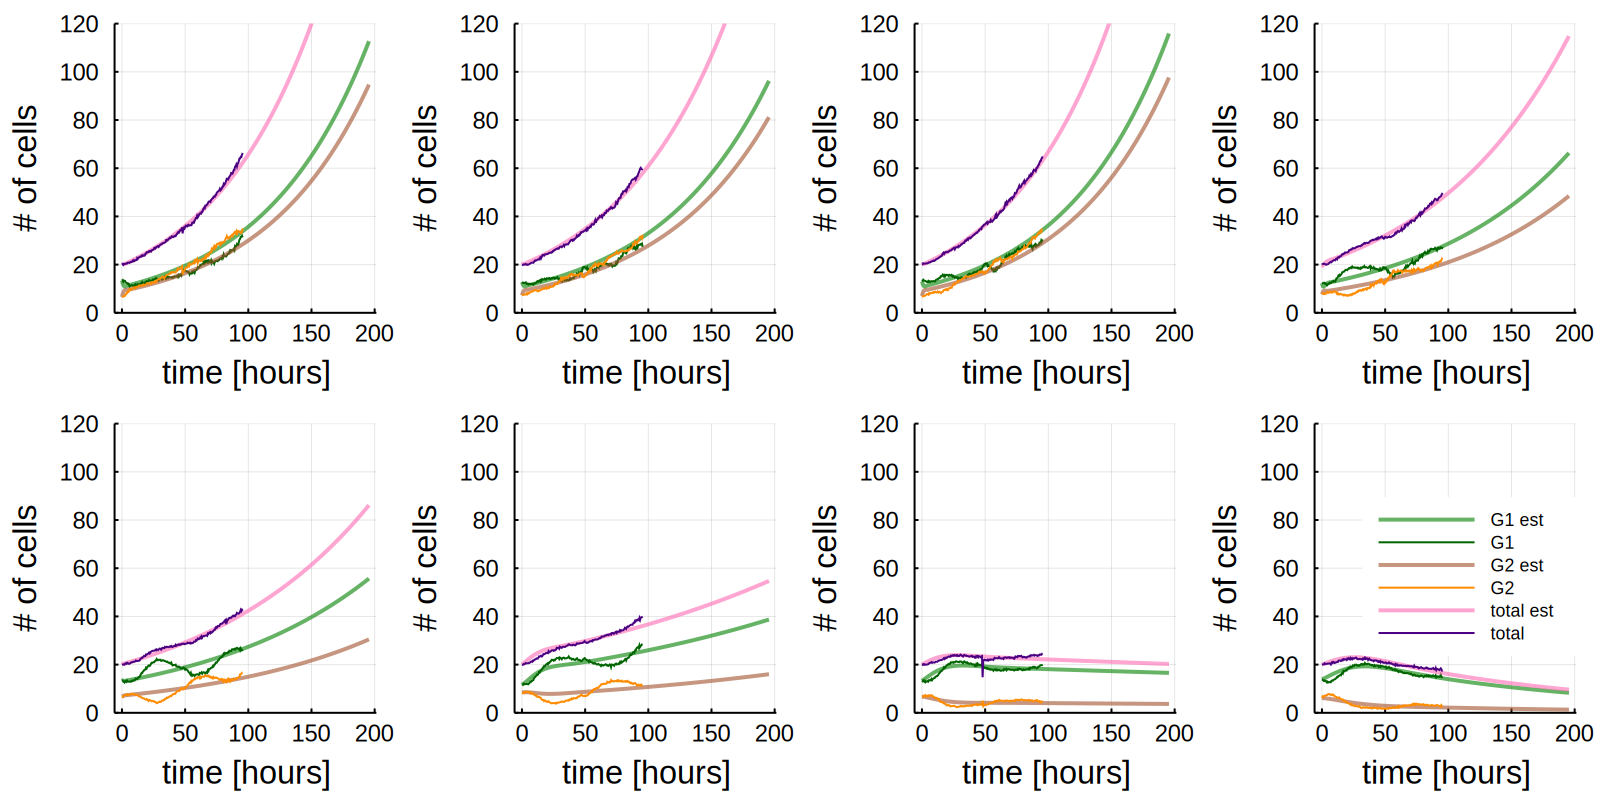

In [7]:
ODEplot_all4(params_ode, g1, g2, g1_0, g2_0, pop)

In [8]:
using DifferentialEquations, Plots, ParameterizedFunctions, Random, Distributions, Turing, StatsPlots, RecursiveArrayTools

predator_prey = @ode_def begin
    du = (alpha - beta*v) * u
    dv = (-gamma + delta * u) * v
    end alpha beta gamma delta

#  "Experimental" data generation
u0 = [10.0, 10.0]
tspan = (0.0, 40.0)
p = [1.1,0.4,0.4, 0.1]
tp= collect(range(0,stop=40))
prob = ODEProblem(predator_prey, u0, tspan, p)
sol = solve(prob, saveat=tp)
# optional plot
# plot(sol, linestyle=:dot)
# modify data with adding gaussian noise
d1 = Normal(0, 0.5)
d2 = Normal(0, 0.5)
newsol = VectorOfArray(sol.u)[:,:]

newsol[1,:] = newsol[1,:] + rand(d1,length(tp))
newsol[2,:] = newsol[2,:] + rand(d2,length(tp))

function test_f(p, tp_save)
  _prob = remake(prob;u0=convert.(eltype(p),prob.u0),p=p)
  solve(_prob,Rodas4(),saveat=tp_save;abstol=1e-6, reltol= 1e-6)
end

plot(sol)
scatter!(tp,newsol[1,:])
scatter!(tp,newsol[2,:])

# define statistical model
@model bayes_predator_prey(x, tp_x) = begin
  alpha ~ Normal(1.0, 0.2)
  beta ~ Normal(0.5, 0.2)
  gamma ~ Normal(0.5, 0.2)
  delta ~ Normal(0.1, 0.1)
  # gather parameters and solve equation
  p = [alpha, beta, gamma ,delta]
  sol_tmp = test_f(p, tp_x)
  # hope that it's likelihood
  N = length(tp_x)

  fill_length = length(tp_x) - length(sol_tmp.u)

  for i in 1:fill_length
    if eltype(sol_tmp.u) <: Number
      push!(sol_tmp.u, Inf)
    else
      push!(sol_tmp.u, fill(Inf, size(sol_tmp[1])))
    end
  end

  for i in 1:N
    x[:,i] ~ MvNormal(sol_tmp.u[i], [0.5,0.5])
  end
end

# run the sampling
chain = sample(bayes_predator_prey(newsol, tp), HMC(0.1, 5), 100)

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ DiffEqBase /home/farnazm/.julia/packages/DiffEqBase/cwiDm/src/integrator_interface.jl:333
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/farnazm/.julia/packages/AdvancedHMC/1ngch/src/hamiltonian.jl:45
Sampling   1%|▎                              |  ETA: 0:00:34┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ DiffEqBase /home/farnazm/.julia/packages/DiffEqBase/cwiDm/src/integrator_interface.jl:333
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/farnazm/.julia/packages/AdvancedHMC/1ngch/src/hamiltonian.jl:45
┌ Warning: dt <= dtmin. Aborting. There is either an error in your

Object of type Chains, with data of type 100×13×1 Array{Union{Missing, Real},3}

Iterations        = 1:100
Thinning interval = 1
Chains            = 1
Samples per chain = 100
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, n_steps, nom_step_size, step_size
parameters        = alpha, beta, delta, gamma

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 1 columns
│ Row │ parameters │ mean     │ std         │ naive_se    │ mcse    │ ess     │
│     │ Symbol     │ Float64  │ Float64     │ Float64     │ Missing │ Any     │
├─────┼────────────┼──────────┼─────────────┼─────────────┼─────────┼─────────┤
│ 1   │ alpha      │ 0.908624 │ 2.23163e-16 │ 2.23163e-17 │ missing │ 2.04082 │
│ 2   │ beta       │ 1.288    │ 0.0         │ 0.0         │ missing │ 2.04082 │
│ 3   │ delta      │ 1.79733  │ 4.46326e-16 │ 4.46326e-17 │ missing │ 2.04082 │
│ 4   │ gamma      │ 0.549218 │ 1.11582e-16 │ 1.11582e-17 │ missing

In [9]:
a = [0.1 0.05; 0.5 0.9]

2×2 Array{Float64,2}:
 0.1  0.05
 0.5  0.9 

In [10]:
a[1] + a[3]

0.15000000000000002